# Fast front-prop

Fast front-prop implementation on matrices (see original `front-prop` idea in original notebook).
This one is ~100x faster, by parallelising all neurons in the layer.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm

import importlib


In [13]:
# If there's a GPU available...
if torch.cuda.is_available():  
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


In [14]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


In [15]:
"""
Calculate discrete entropy for continuous values, by binning them.
Note this is Shannon's measure of information entropy.
Not cross-entropy loss, used commonly in training.

TODO: check if this is correct
"""
def entropy(numbers, range=(0, 1), bins=100):
    # h, bin_edges = np.histogram(numbers, bins=bins, density=False, range=range)
    # h = h / h.max() # normalise
    # entropy = scipy.stats.entropy(h)

    # Calculate histogram
    hist = torch.histc(numbers, bins=bins, min=range[0], max=range[1])
    # Normalize histogram
    hist /= hist.max()
    # Calculate entropy
    hist += torch.finfo(torch.float32).eps
    entropy = -(hist * torch.log2(hist)).sum()

    return entropy


In [16]:
import torch

def sphere_rnd_gen(n, d):
    """
    Generate n random points on a d-dimensional sphere.
    See https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere

    This is essential if we're normalising to unit length (ie projecting onto a hypersphere),
    because a uniform distribution from a unit cube won't be uniform on the sphere.
    """
    x = torch.randn(n, d)
    x /= torch.norm(x, dim=1, keepdim=True)
    return x

## Simple patterns

In [17]:
# Define input patterns

DIMS = [7,7]

patterns = [
    torch.tensor([
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,0,1,0,0],
        [0,0,0,1,0,0,0],
        [0,0,1,0,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1]
    ]),
    torch.tensor([
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [1,1,1,1,1,1,1],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0],
        [0,0,0,1,0,0,0]
    ]),
    torch.tensor([
        [0,0,1,1,1,0,0],
        [0,1,0,0,0,1,0],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [1,0,0,0,0,0,1],
        [0,1,0,0,0,1,0],
        [0,0,1,1,1,0,0]
    ]),
    torch.tensor([
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0]
    ]),
    torch.tensor([
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [1,1,1,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0]
    ])
# np.array([
# [0,1,1,0],
# [1,0,0,1],
# [1,0,0,1],
# [0,1,1,0]
# ])
]

# Define probabilities

probs = np.full(len(patterns), 1) # np.array([0.43 0.43 0.13])
probs = probs / probs.sum()



In [18]:
# plot the 2D matrix heatmap
# supports a 2D array, or flattened (uses DIMS to restore 1D to 2D)
def plot_matrix(dims, *datas):
    PLOTS_PER_ROW = 20
    cols = min(len(datas), PLOTS_PER_ROW)
    rows = math.ceil(len(datas)/PLOTS_PER_ROW)
    fig = plt.figure(figsize=(cols,rows))
    for i, data in enumerate(datas):
        data = data.cpu().numpy()
        if data.shape != dims:
            data = np.reshape(data, dims)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(data, cmap='gray')
        plt.axis('off')
        # plt.title(f"#{i}")
    plt.show()


----------------
Running frontprop on following patterns:


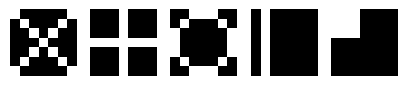

with probabilities:
[0.20 0.20 0.20 0.20 0.20]



 --- Iter #0 --- 


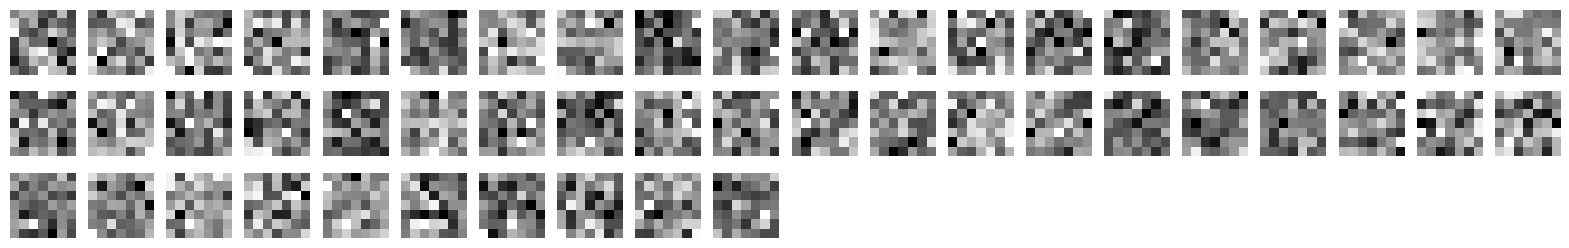

Layer outputs:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan]], device='cuda:0')

 --- Iter #2000 --- 


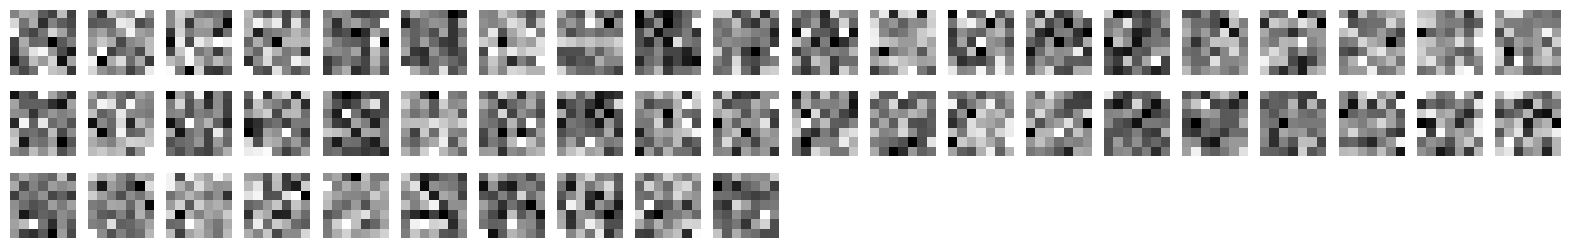

Layer outputs:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan]], device='cuda:0')

 --- Iter #4000 --- 


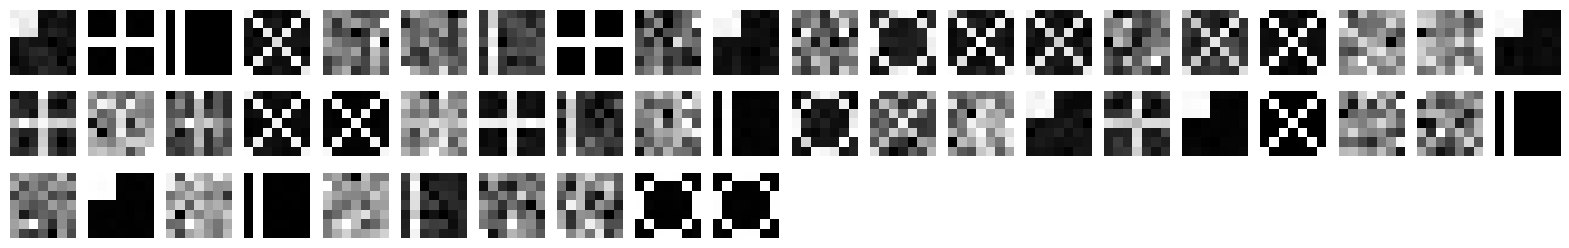

Layer outputs:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4990, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.4990, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.5010, 0.5010]], device='cuda:0')

 --- Iter #6000 --- 


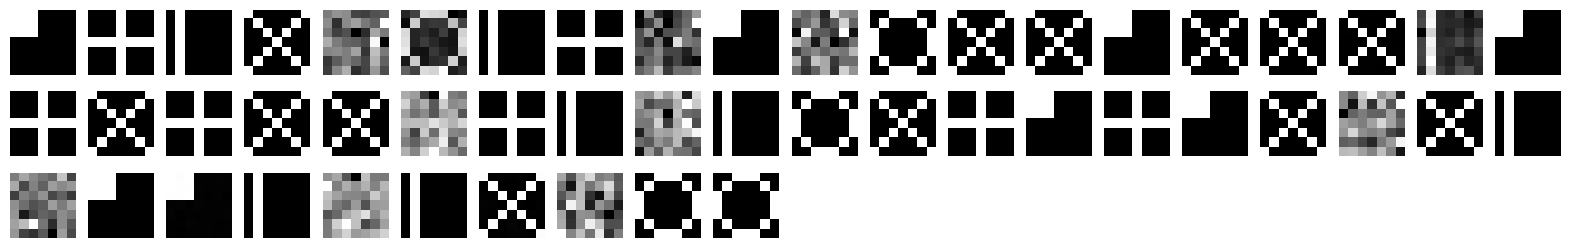

Layer outputs:
tensor([[0.0000, 0.0000, 0.0000, 0.2774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.2774, 0.2774, 0.0000, 0.2774, 0.2774, 0.2773,
         0.0000, 0.0000, 0.0000, 0.2774, 0.0000, 0.2774, 0.2774, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2774, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2774, 0.0000, 0.2774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2773, 0.0000, 0.0000, 0.0000]], device='cuda:0')

 --- Iter #8000 --- 


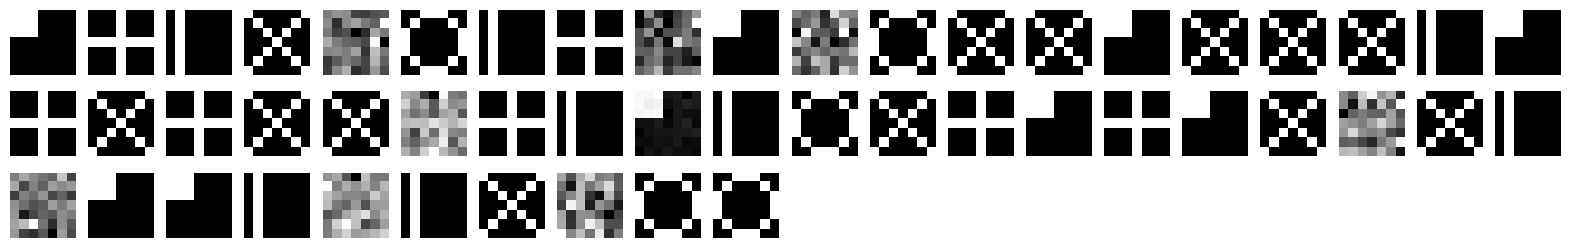

Layer outputs:
tensor([[0.0000, 0.3780, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3780, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3780, 0.0000, 0.3780, 0.0000, 0.0000, 0.0000, 0.3780,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3780, 0.0000, 0.3780, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


In [20]:
import torch_module as fp

ITERS = 10000 # 50000
NEURONS = 50
DRAW_INTERVAL = 2000
VERBOSE=False

layer = fp.FpLinear(DIMS[0]*DIMS[1], NEURONS, device=device)

print("\n----------------\nRunning frontprop on following patterns:")
plot_matrix(DIMS, *patterns)
print(f"with probabilities:\n{probs}\n\n")

# FIXME
patterns = [p.float().to(device) for p in patterns]

for i in range(ITERS):

    input_idx = np.random.choice(len(probs), p=probs)
    input = patterns[input_idx].flatten().unsqueeze(0)

    if VERBOSE:
        print(f"Iter #{i}: Feeding input pattern #{input_idx}")
        print(input)
        plot_matrix(input)
        
    out = layer.forward(input)
    
    if i % DRAW_INTERVAL == 0:
        print(f"\n --- Iter #{i} --- ")
        plot_matrix(DIMS, *([layer.weight[i] for i in range(NEURONS)]))
        print("Layer outputs:")
        print(out)
        

## MNIST

In [21]:
import torchvision
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_train = mnist_trainset.data.to(device) # .cpu().detach().numpy()
mnist_train_labels = mnist_trainset.targets.to(device) # .cpu().detach().numpy()

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_test = mnist_testset.data.to(device) # .cpu().detach().numpy()
mnist_test_labels = mnist_testset.targets.to(device) # .cpu().detach().numpy()

# normalise to 0-1
mnist_train = mnist_train / 256.0
mnist_test = mnist_test / 256.0

(mnist_train.shape, mnist_train_labels.shape, mnist_test.shape, mnist_test_labels.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))


----------------
Running frontprop on MNIST

 === Epoch #0 === 


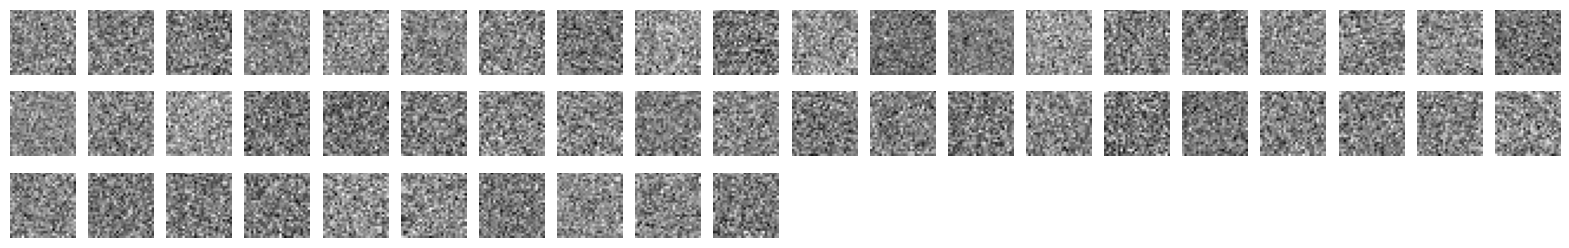

  0%|          | 0/60000 [00:00<?, ?it/s]

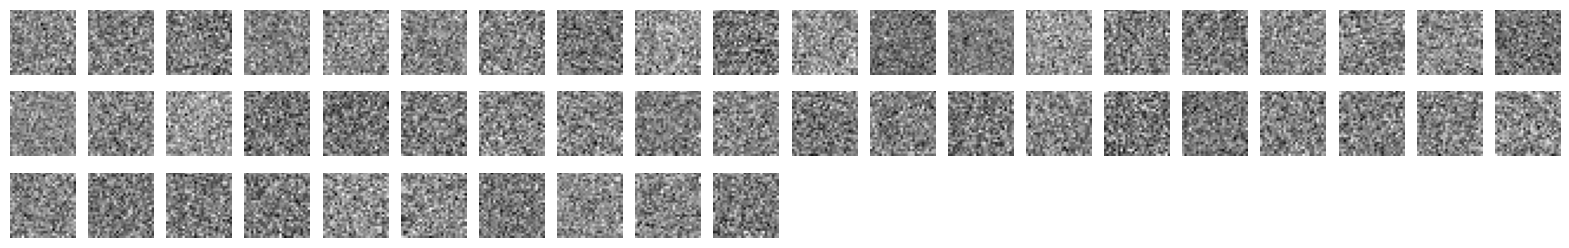

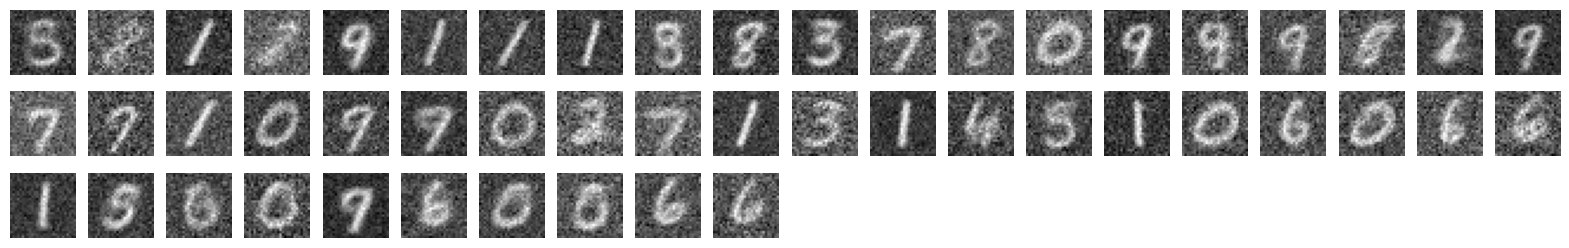

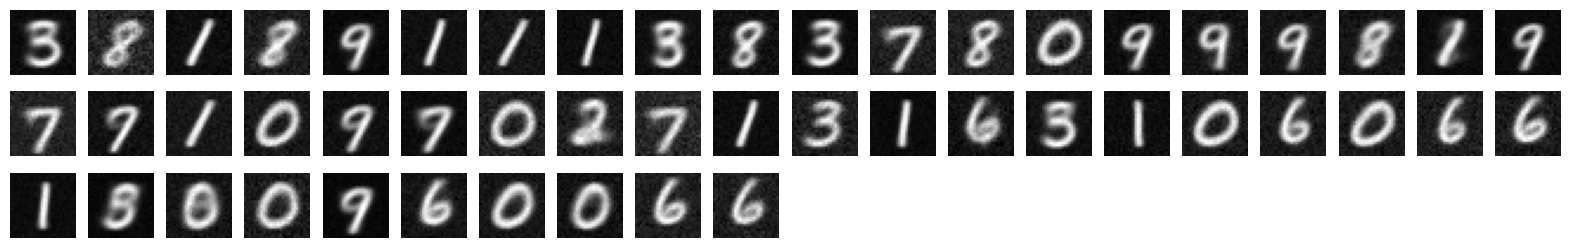

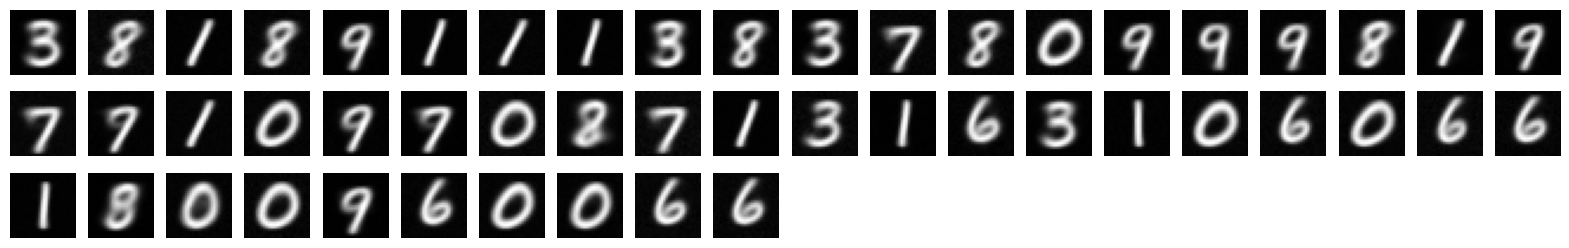

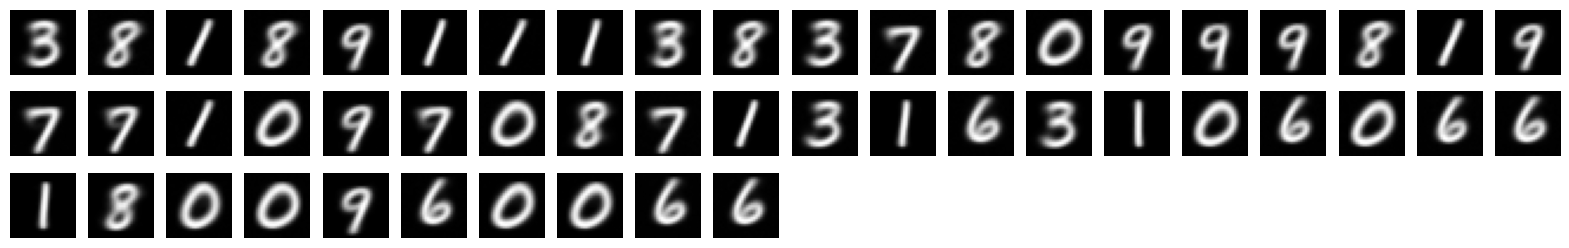

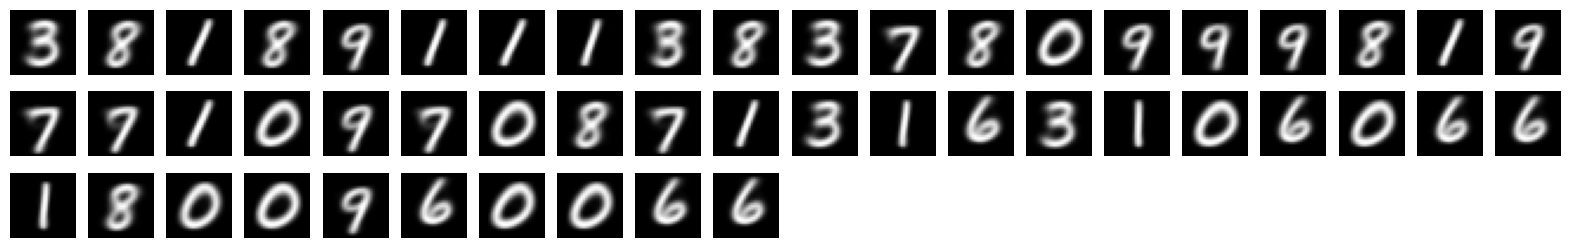

In [22]:
EPOCHS = 1
NEURONS = 50
THRESHOLD_DECAY=0.001
WEIGHT_BOOST=0.01

DIMS = [28, 28]
STATS_INTERVAL = 10000

layer1 = fp.FpLinear(DIMS[0]*DIMS[1], NEURONS, t_decay=THRESHOLD_DECAY, w_boost=WEIGHT_BOOST, device=device)

print("\n----------------\nRunning frontprop on MNIST")

for epoch in range(EPOCHS):
    
    print(f"\n === Epoch #{epoch} === ")
    
    plot_matrix(DIMS, *([layer1.weight[i] for i in range(NEURONS)]))
    
    indices = np.arange(mnist_train.shape[0])
    np.random.shuffle(indices)
    
    for i, input_idx in enumerate(tqdm(indices)):

        input1 = mnist_train[input_idx].flatten().unsqueeze(0)

        out1 = layer1.forward(input1)

        if i % STATS_INTERVAL == 0:
            plot_matrix(DIMS, *([layer1.weight[i] for i in range(NEURONS)]))
    

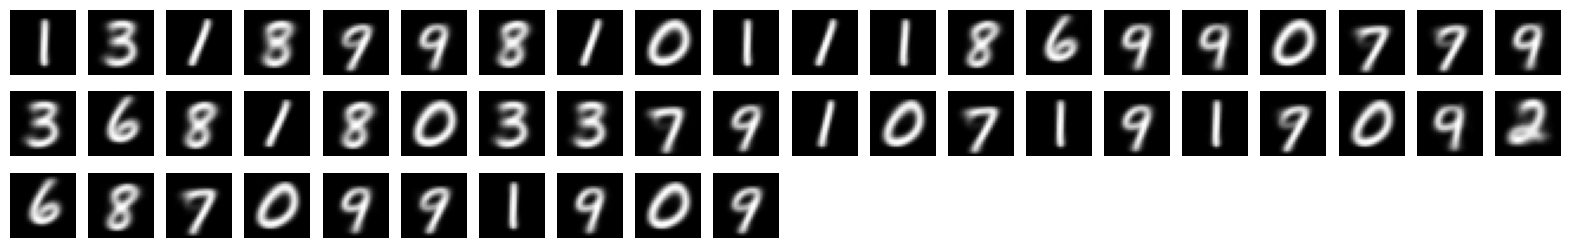

In [16]:
plot_matrix(DIMS, *([layer1.weight[i] for i in range(NEURONS)]))